## Agricultural Field Boundary Detection in Ens, Flevoland Using OpenCV
### Data Loading

In [ ]:
import rasterio
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

import cv2
import geopandas as gpd
from shapely.geometry import shape
import rasterio.features
from rasterio.features import rasterize

In [ ]:
# Opening the raster file
data_1 = rxr.open_rasterio("data/5.tif")

# Selecting the RGB bands
img_1 = data_1.sel(band=([1,2,3]))

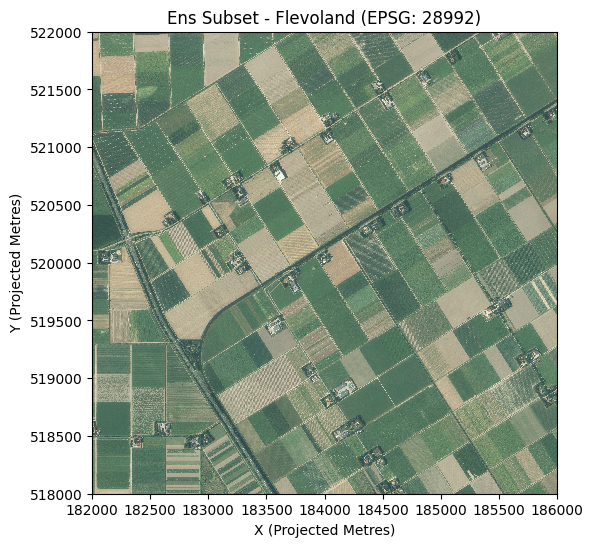

In [ ]:
# Plotting the subset in true colour
plt.figure(figsize=(6,6))
img_1.plot.imshow()

plt.title('Ens Subset - Flevoland (EPSG: 28992)')
plt.xlabel('X (Projected Metres)')
plt.ylabel('Y (Projected Metres)')
plt.show()

### Pre-processing

In [ ]:
# Rearranging bands for OpenCV later
rgb_1 = np.transpose(img_1.data, (1,2,0))

# Applying Gaussian blur with different parameters
denoised_1 = cv2.GaussianBlur(rgb_1, (5,5), 1)
denoised_2 = cv2.GaussianBlur(rgb_1, (5,5), 2)
denoised_3 = cv2.GaussianBlur(rgb_1, (5,5), 3)

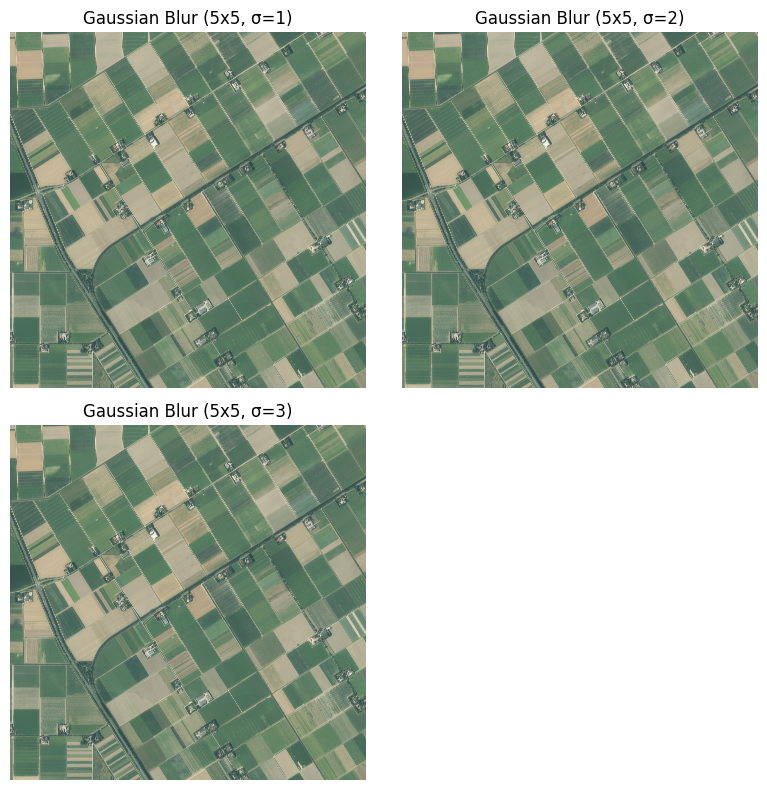

In [ ]:
# Plotting the Gaussian blur results
fig_1, ax_1 = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
axes_1 = ax_1.flatten()

axes_1[0].imshow(denoised_1)
axes_1[0].set_title('Gaussian Blur (5x5, σ=1)')
axes_1[0].axis('off')

axes_1[1].imshow(denoised_2)
axes_1[1].set_title('Gaussian Blur (5x5, σ=2)')
axes_1[1].axis('off')

axes_1[2].imshow(denoised_3)
axes_1[2].set_title('Gaussian Blur (5x5, σ=3)')
axes_1[2].axis('off')

fig_1.delaxes(axes_1[3])

plt.tight_layout()
plt.show()

σ=2 was chosen as the Gaussian Blur parameter to balance noise removal and line integrity.

### Edge Detection

In [ ]:
# Converting RGB data to BGR and grayscale data for OpenCv
bgr_1 = cv2.cvtColor(denoised_1, cv2.COLOR_RGB2BGR)
gray_1 = cv2.cvtColor(bgr_1, cv2.COLOR_BGR2GRAY)

# Applying Canny edge detection with different parameters
edges_1 = cv2.Canny(gray_1, threshold1=50, threshold2=100)
edges_2 = cv2.Canny(gray_1, threshold1=75, threshold2=150)
edges_3 = cv2.Canny(gray_1, threshold1=100, threshold2=150)

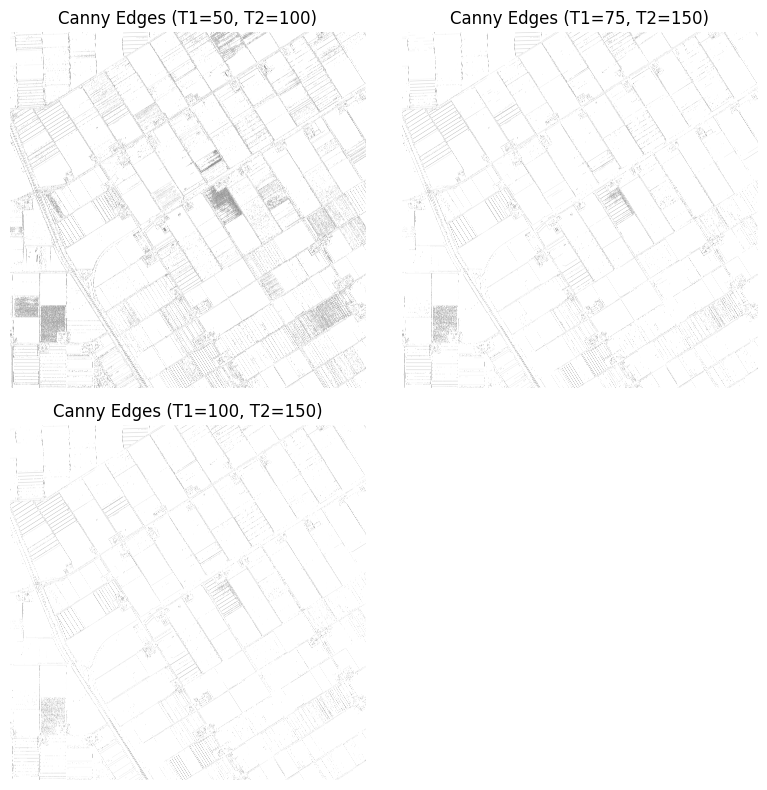

In [ ]:
# Plotting the Canny edge detection results
fig_2, ax_2 = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
axes_2 = ax_2.flatten()

axes_2[0].imshow(edges_1, cmap='binary')
axes_2[0].set_title('Canny Edges (T1=50, T2=100)')
axes_2[0].axis('off')

axes_2[1].imshow(edges_2, cmap='binary')
axes_2[1].set_title('Canny Edges (T1=75, T2=150)')
axes_2[1].axis('off')

axes_2[2].imshow(edges_3, cmap='binary')
axes_2[2].set_title('Canny Edges (T1=100, T2=150)')
axes_2[2].axis('off')

fig_2.delaxes(axes_2[3])

plt.tight_layout()
plt.show()

Thresholds T1=50 and T2=100 were selected to preserve line integrity.

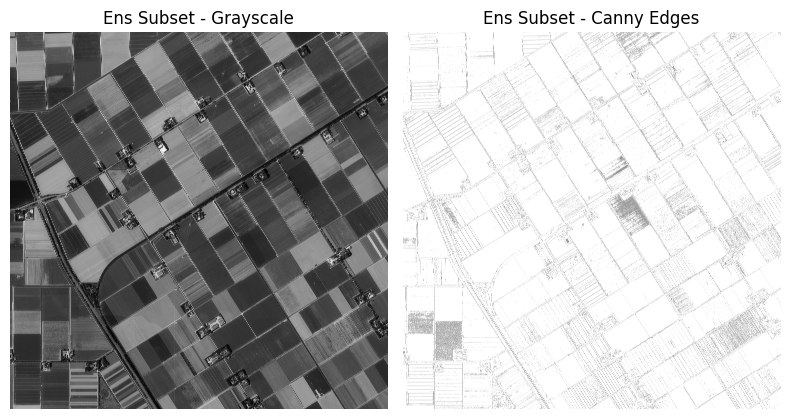

In [ ]:
# Plotting the grayscale and Canny edges images
fig_3, ax_3 = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes_3 = ax_3.flatten()

ax_3[0].imshow(gray_1, cmap='gray')
ax_3[0].set_title('Ens Subset - Grayscale')
ax_3[0].axis('off')

ax_3[1].imshow(edges_1, cmap='binary')
ax_3[1].set_title('Ens Subset - Canny Edges')
ax_3[1].axis('off')

plt.tight_layout()
plt.show()

### Post-processing

In [ ]:
# Defining a 5x5 kernel 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

# Applying dilation (thickening lines)
dilated = cv2.dilate(edges_1, kernel, iterations=1)

# Applying closing (filling small gaps)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

# Applying opening (removing noise)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

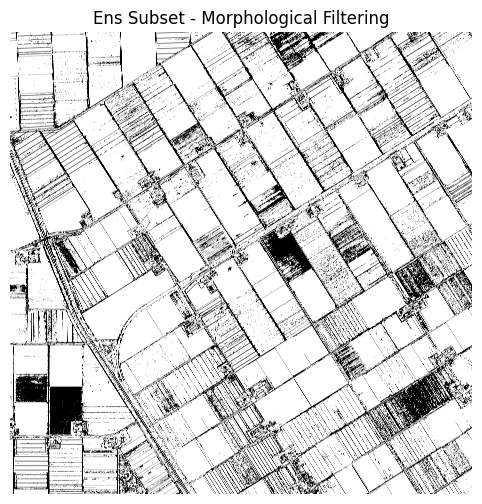

In [ ]:
# Plotting the morphological filtering results
plt.figure(figsize=(8,6))
plt.imshow(opened, cmap='binary')

plt.title('Ens Subset - Morphological Filtering')
plt.axis('off')
plt.show()

### Extracting Polygons

In [ ]:
# Creating a binary bask
mask_src = opened
mask_bin = (mask_src > 0).astype(np.uint8)

# Getting affine transformation values
transform = img_1.rio.transform()

# Extracting polygons from the binary mask
polys = []
for geom, val in rasterio.features.shapes(mask_bin, transform=transform):
    if val == 1:
        polys.append(shape(geom))

# Building a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polys, crs=img_1.rio.crs)

# Filtering out noise, and simplifying shapes
gdf = gdf[gdf.area >= 500]
gdf['geometry'] = gdf.geometry.buffer(0).simplify(0.5, preserve_topology=True)

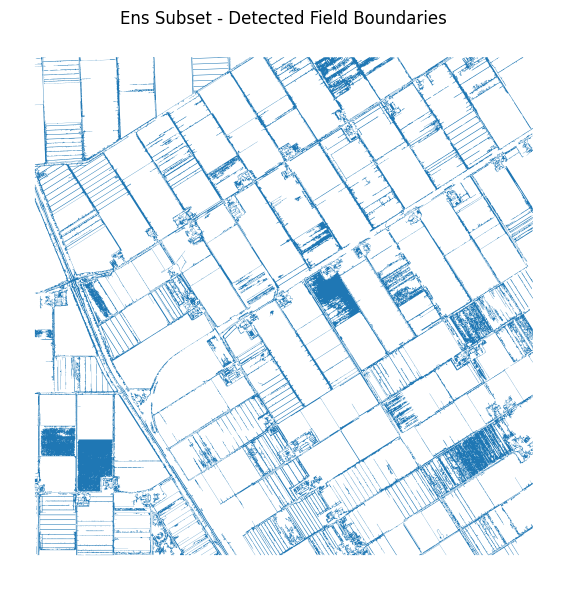

In [ ]:
# Plotting detected field boundaries
fig_4, ax_4 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
gdf.plot(ax=ax_4)
ax_4.set_title('Ens Subset - Detected Field Boundaries')
ax_4.axis('off')

plt.tight_layout()
plt.show()

### Rasterisation

In [ ]:
# Getting the grid size and CRS values
height = img_1.sizes['y']
width = img_1.sizes['x']
crs = img_1.rio.crs

# Creating a list of polygons
shapes = [(geom, 1) for geom in gdf.geometry]

# Rasterising the polygons in the list
rast = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    default_value=1,
    dtype='uint8',
    all_touched=False
)

# Wrapping results into a DataArray
rast_da = xr.DataArray(
    rast[np.newaxis, ...],
    dims={'band': [1], 'y': img_1.y, 'x': img_1.x},
    name='parcels_mask'
)

# Attaching CRS and transform to the DataArray
rast_da.rio.write_crs(crs, inplace=True)
rast_da.rio.write_transform(transform, inplace=True)

<xarray.DataArray 'parcels_mask' (band: 1, y: 16000, x: 16000)> Size: 256MB
array([[[0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 ...,
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 16000, 16000), dtype=uint8)
Coordinates:
 spatial_ref int64 8B 0
Dimensions without coordinates: band, y, x xarray.DataArray 'parcels_mask' band : 1 y : 16000 x : 16000 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 array([[[0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 ...,
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0],
 [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 16000, 16000), dtype=uint8) Coordinates: (1) spatial_ref () int64 0 crs_wkt : PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]] spatial_ref : PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]] GeoTransform : 182000.0 0.25 0.0 522000.0 0.0 -0.25 array(0) Indexes: (0) Attributes: (0)

### Exporting Results

In [ ]:
# Exporting results as a GeoJSON file
gdf.to_file('data/output_vector.geojson', layer='parcels', driver='GeoJSON')

# Exporting results as a TIFF file
rast_da.rio.to_raster('data/output_raster.tif', nodata=0)